In [5]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re
import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os, sys
os.environ["OPENBLAS_NUM_THREADS"]="1"

import random
import scipy.sparse as sparse

np.set_printoptions(threshold=sys.maxsize)

#from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

# Read in the data from the Mongo collection

#prod_song, prod_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

## Producers/ Songs/ Samples left to go through.


In [9]:
prods_in_df = set(db.main_redo.distinct('new_song_producer'))

print("Total: {}".format(len(prods_in_df)))

prods_done = set(db.exhaustive_producers.distinct('dj'))
print("Done: {}".format(len(prods_done)))
      
producers_to_do = prods_in_df.difference(prods_done)
print('To Do: {}'.format(len(producers_to_do)))

print(len(prods_in_df) - (len(producers_to_do) + len(prods_done)))

Total: 18990
Done: 5090
To Do: 14203
-303


In [13]:
#pages we've done
df = pd.DataFrame(list(db.main_redo.find()))
done_URLS = set(df.URL.unique())

print(len(done_URLS))
#total pages we have links to
song_sample_pages = db.song_sample_pages.find({}, {"link": 1, "_id": 0})
song_sample_pages = set([element['link'] for element in song_sample_pages])

print("total pages we have links to: {}".format(len(song_sample_pages)))

#total pages we've left
song_sampled_pages_to_do = song_sample_pages.difference(done_URLS)

print("Number of pages we've left: {}".format(len(song_sampled_pages_to_do)))


KeyboardInterrupt: 

Without outliers removed, the mean and median time of sample appearance is 1:03 and 0:17, respectively.
With outliers removed, the mean and median are 0:56 and 0:16.


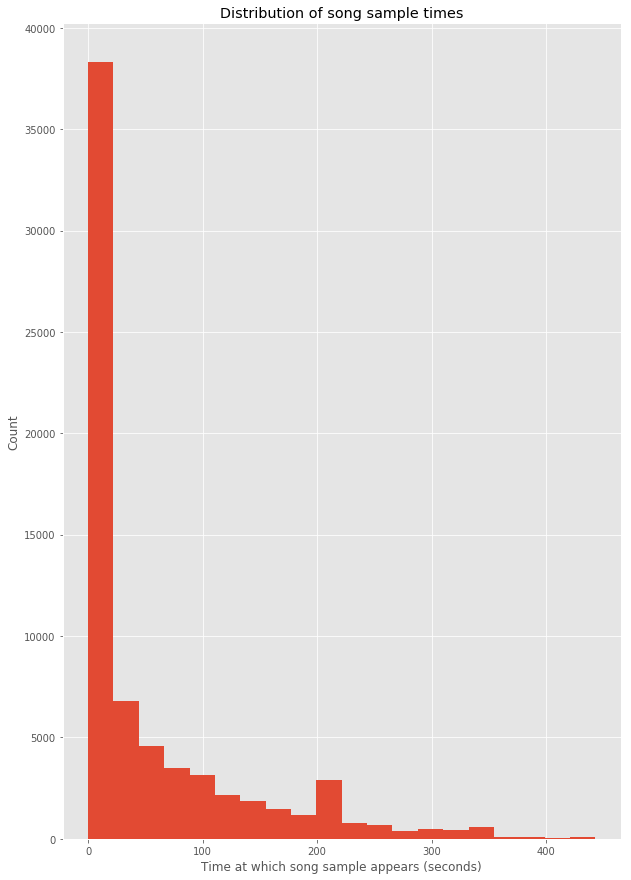

In [62]:
#Plot distribution of song_sample_times

subset = df.sample(n = 50)

# #Filter out "None Listed" in the time column
df = df[df.time_in_sampled_song_where_sample_appears != "None Listed"]

df = df[df.time_in_sampled_song_where_sample_appears.str.contains(":")]

# #Make new column with the number of seconds into a song the sample appears.
df['seconds_into_song'] = \
        df.time_in_sampled_song_where_sample_appears.apply(
        lambda x: x.split(":")).apply(
        lambda x: int(x[0]) * 60 +int(x[1]))

def get_mean_or_median_from_column(column, stat):
    '''
    Get mean in seconds and time format
    Put mean_minutes and seconds together to make time
    ''' 
    #Get mean or median of the column
    agg = int(stat(column))
    
    minutes = str(int(agg / 60))
    seconds = agg % 60    
    if seconds > 9:
        time = minutes + ":" + str(seconds)
    else: 
        time = minutes + ":0" + str(seconds)
    return time

def filter_df_outside_three_sds(column, df):
    
    '''
    Takes a column and calculates mean and std, then removes anything above that outer outlier bound.
    '''
    standard_deviation = column.std()
    outer_outlier_bound = np.mean(column) + 3 * standard_deviation
    filtered_df = df[column < outer_outlier_bound]
    return filtered_df

mean_time = get_mean_or_median_from_column(df.seconds_into_song, np.mean)
median_time = get_mean_or_median_from_column(df.seconds_into_song, np.median)

filtered_df = filter_df_outside_three_sds(df.seconds_into_song, df)

filtered_mean_time = get_mean_or_median_from_column(filtered_df.seconds_into_song, np.mean)
filtered_median_time = get_mean_or_median_from_column(filtered_df.seconds_into_song, np.median)

print(
"Without outliers removed, the mean and median time of sample appearance is {} and {}, respectively.\n\
With outliers removed, the mean and median are {} and {}."
    .format(mean_time, median_time, filtered_mean_time, filtered_median_time))

fig, ax = plt.subplots(figsize = (10, 15))
# ax.boxplot(filtered_subset.seconds_into_song)
ax.set(xlabel = "Time at which song sample appears (seconds)", ylabel = "Count", title = "Distribution of song sample times")
_ = ax.hist(filtered_df.seconds_into_song, bins = 20)

0
0
Earliest sampled year in dataset is 1241. Latest is 2018
sampled_song_year
1241       1
1500       1
1600       2
1601       1
1680       6
1698       4
1707      10
1714       1
1719       2
1721       2
1722       1
1723       4
1730       1
1733       1
1734       1
1736       1
1738       1
1742       2
1744       7
1760       5
1765       3
1770       3
1773       1
1775       1
1777      29
1779       1
1780       7
1783       2
1784       1
1787       2
        ... 
1989     844
1990     916
1991     937
1992    1009
1993    1245
1994    1343
1995    1097
1996     861
1997     804
1998     655
1999     666
2000     717
2001     518
2002     400
2003     480
2004     346
2005     363
2006     288
2007     306
2008     264
2009     298
2010     330
2011     464
2012     345
2013     384
2014     206
2015     275
2016     135
2017     100
2018      49
Name: URL, Length: 185, dtype: int64
Year with most samples is 1973, with 4492 samples


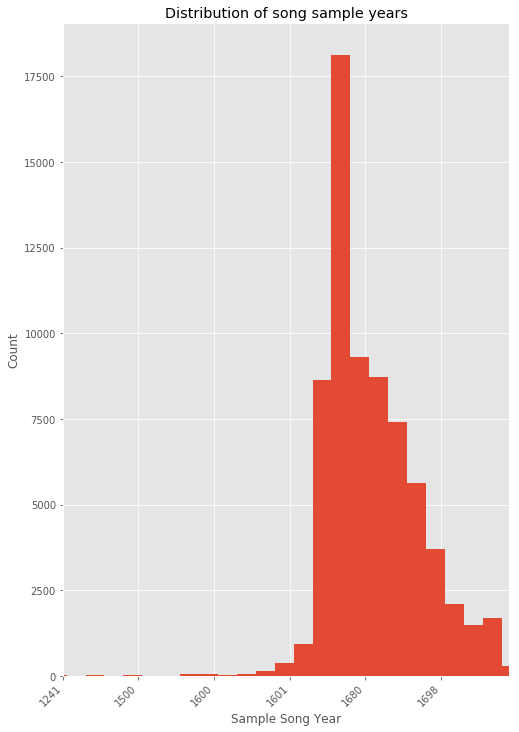

In [65]:
# What year has most sampled artist?
# Or we get the range of years tht had most

def plot_distribution_of_years(column, df):
    
    df = df[df[column] != "None Listed"]
    df = df[df[column] != 0]
    
    print(len(df[df[column] == "None Listed"]))
    print(len(df[df[column] == 0]))

    min_year = df[column].astype(int).min()
    max_year = df[column].astype(int).max()
    print("Earliest sampled year in dataset is {}. Latest is {}".format(min_year, max_year))

    df = filter_df_outside_three_sds(df[column], df)

    sampled_year_counts = df.groupby(df[column]).agg(len)['URL']
    print("Year with most samples is {}, with {} samples".format(sampled_year_counts.idxmax(), sampled_year_counts.max()))

    fig, ax = plt.subplots(figsize = (8, 12))
    ax.hist(df[column].astype(int), density = False, bins = range(min_year, max_year +5, 5))
    ax.set_xticklabels(sampled_year_counts.index, rotation = 45, ha = 'right')
    ax.set_xlim([1900, 2018])
    _ = ax.set(xlabel = "Sample Song Year", ylabel = "Count", title = "Distribution of song sample years")

plot_distribution_of_years('sampled_song_year', df)
# _ = ax[1].bar(x = sampled_year_counts.index, height = sampled_year_counts.values)

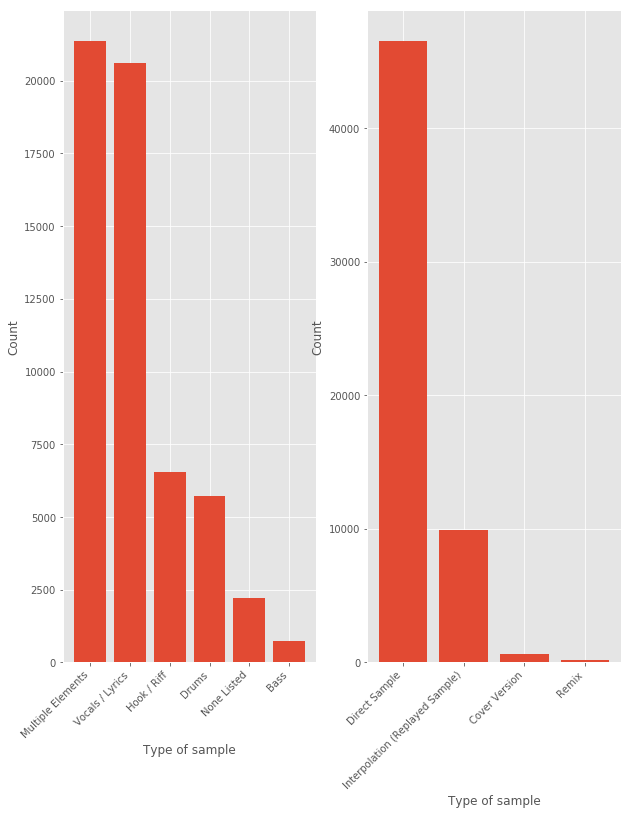

In [545]:
#Are they direct sample or interpolations?
subset = df.sample(n = 100)
df = df[df.sampled_song_year != "None Listed"]

#split into types and elements
df['type_of_sample'] = df.elements_sampled.apply(lambda x: x.split("of")[0].strip() if "of" in x else x)
df['elements_sampled'] = df.elements_sampled.apply(lambda x: x.split("of")[1].strip() if "of" in x else "None Listed")

elements_counts = df.groupby(df.elements_sampled).agg(len)['URL'].sort_values(ascending = False)
type_counts = df.groupby(df.type_of_sample).agg(len)['URL'].sort_values(ascending = False)

fig, ax  = plt.subplots(nrows = 1, ncols =2, figsize = (10,12))

for position, graph in zip([0,1], [elements_counts, type_counts]):
    
    ax[position].set_xticklabels(graph.index, rotation = 45, ha = 'right')
    ax[position].bar(x = graph.index, height = graph.values)
    ax[position].set(xlabel = "Type of sample", ylabel = "Count", label = "Sample Type Distributions")

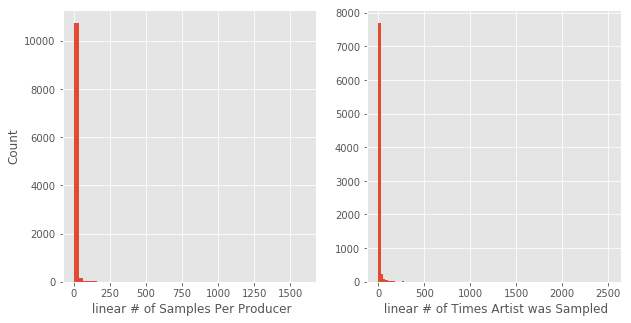

In [45]:
#     prod_with_most_samples = util_mat.sum(axis = 0).idxmax()
#     most_sampled_artist = util_mat.sum(axis = 1).idxmax()
#     most_samples = util_mat.sum(axis = 0).max()
#     times_sampled = util_mat.sum(axis = 1).max()
# print(
#     "{} is the producer with the most samples, with {} unique sampling instances.\n\
#     {} is the most sampled artist, sampled {} times.".format(
#             prod_with_most_samples, most_samples, most_sampled_artist, times_sampled))

def plot_distributions_of_numbers_sampled(util_mat, scale):
    producers = util_mat.sum(axis =0)
    sampled_artists = util_mat.sum(axis =1)
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    ax[0].set(xlabel = " {} # of Samples Per Producer".format(scale), ylabel = "Count")
    _ = ax[0].hist(producers, bins = 50)

    # ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
    #             arrowprops=dict(facecolor='black', shrink=0.05),
    #             )
    ax[1].set(xlabel = " {} # of Times Artist was Sampled".format(scale))
    _ = ax[1].hist(sampled_artists, bins = 100)

plot_distributions_of_numbers_sampled(artist_prod, 'Linear')

## Log transform the artist_prod data.

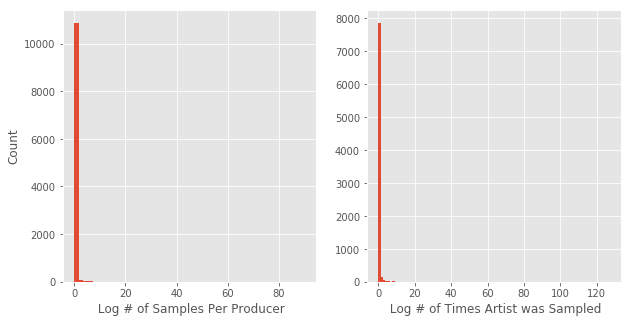

In [55]:
import math
artist_prod_log = artist_prod.applymap(lambda x: math.log(x, 30) if x != 0 else 0)
plot_distributions_of_numbers_sampled(artist_prod_log, 'Log')

#log 10 still looks very skewed.
#they used log 6.
#Log 20 still skewed.

In [41]:
# Top ten producers

artist_prod.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1599
J Dilla,1196
9th Wonder,1123
DJ Premier,1076
Pete Rock,1025
The Alchemist,965
DJ Paul,939
Juicy J,826
Dr. Dre,793


In [12]:
# Top ten most sampled artists

artist_prod.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
James Brown,1913
Beside,1775
Kool & the Gang,1311
Public Enemy,613
"Earth, Wind & Fire",561
"Funk, Inc.",492
The Notorious B.I.G.,472
Skull Snaps,457
Jay-Z,405


In [6]:
# How sparse is matrix?
for ut_mat, label in zip([prod_artist, prod_song], ["Artist Matrix", "Song Matrix"]):
    matrix_size = ut_mat.shape[0]*ut_mat.shape[1] # Number of possible interactions in the matrix
    nonzeros = sum(ut_mat.sum(axis=0))
    sparsity = 100*(1 - (nonzeros/matrix_size))
    print("{} has {} interactions out of {} possible, resulting in a {} % sparse matrix"
          .format(label, nonzeros, matrix_size, round(sparsity, 3)))

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

Artist Matrix has 105957 interactions out of 159321444 possible, resulting in a 99.933 % sparse matrix
Song Matrix has 105957 interactions out of 420207378 possible, resulting in a 99.975 % sparse matrix


In [9]:
prod_artist.head()

new_song_producer,"""Buttnaked"" Tim Dawg","""Coach"" Frank Johnson","""Dope Mix"" Dave","""House Master"" Baldwin","""Spinnin' Wheel"" Bill","""Weird Al"" Yankovic",$Crim,$Outhern,$uicideboy$,'Fro' Master Dee Jay K. Gee,...,Константин Музейник,Константин Цеков,Михей,Павел Галкин,Роман Мясников,Роман Синцов,Сергей Жуков,Томи Димчев,ФСБ,マクロス MACROSS 82-99
sampled_artist,,,,,,,,,,,,,,,,,,,,,
"""Haare"" Ensemble",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Sweet"" Charles Sherrell",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$Ugga & Spice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$uicideboy$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Lee' George Quinones,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_vocals = df[df.elements_sampled == "Direct Sample of Vocals / Lyrics"]

In [24]:
df.elements_sampled.unique()

array(['Direct Sample of Hook / Riff', 'Direct Sample of Vocals / Lyrics',
       'Direct Sample of Drums', 'Direct Sample of Multiple Elements',
       'Direct Sample of Dialogue',
       'Interpolation (Replayed Sample) of Vocals / Lyrics',
       'Direct Sample', 'Interpolation (Replayed Sample) of Hook / Riff',
       'Interpolation (Replayed Sample) of Dialogue',
       'Interpolation (Replayed Sample) of Multiple Elements',
       'Interpolation (Replayed Sample)', 'Direct Sample of Bass',
       'Interpolation (Replayed Sample) of Drums',
       'Interpolation (Replayed Sample) of Bass', 'Remix',
       'Interpolation (Replayed Sample) of Score',
       'Direct Sample of Score', 'Cover Version',
       'Direct Sample of Sound Effect / Other',
       'Interpolation (Replayed Sample) of Sound Effect / Other',
       'None Listed'], dtype=object)

In [23]:
len(df_vocals)

0

In [ ]:
plot_distribution_of_years('new_song_year', df)

## Most time a producer sampled an artist

In [3]:
max_prod_artist = prod_artist.values.max()

print("Most times a producer sampled an artist was {} times".format(max_prod_artist))
#Some producer sampled an artist 124 times!

indices = np.where(prod_artist.values==prod_artist.values.max())   
      
dj = prod_artist.index[indices[0]]
artist = prod_artist.index[indices[1]]
print("{} sampled {} the most times!".format(dj, artist))

NameError: name 'prod_artist' is not defined

In [27]:
# Make train set.
# First, we do in the most basic way: Set one percent of actual 
#interactions to non-interactions. Don't do it by row, just entire dataframe.

#transpose matrix, because he has users as columns (which certainly makes more sense.)
prod_artist_sparse = sparse.csr_matrix(artist_prod.T)

from src.make_train_set import make_train

train_set, test_set, user_rows_altered = make_train(prod_artist_sparse, 0.01)

In [24]:
import pickle
with open('als1.pkl', 'wb') as f:
        # Write the model to a file.
    pickle.dump(model, f)

In [18]:
print(model.item_factors.shape)
print(model.user_factors.shape)

(7846, 5)
(9435, 5)


In [29]:
from src.auc_testing import auc_score, calc_mean_auc

calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)

(0.93, 0.887)

In [22]:
# Record of scores
train_set = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
alpha = 15

def test_different_train_test_split(split, alpha):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, split)
    user_vecs, item_vecs = implicit.als.AlternatingLeastSquares(train_set).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    
scores = [test_different_train_test_split(split, alpha) for split in train_set]

100%|██████████| 50.0/50 [00:08<00:00,  5.73it/s]
100%|██████████| 50.0/50 [00:10<00:00,  3.40it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.88it/s]
100%|██████████| 50.0/50 [00:23<00:00,  1.66it/s]
100%|██████████| 50.0/50 [00:19<00:00,  1.45it/s]
100%|██████████| 50.0/50 [00:16<00:00,  1.84it/s]
100%|██████████| 50.0/50 [00:11<00:00,  6.81it/s]
100%|██████████| 50.0/50 [00:15<00:00,  5.75it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.54it/s]


In [26]:
# The model does best at 5% split.

def grid_search_model(alpha, factor, iteration):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, 0.05)
    user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=factor, 
                                                          regularization = 0.1, 
                                                         iterations = iteration)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    
vals = []
alphas = [1, 10, 20, 50, 100]
factors =[5, 15, 25, 50, 100]
iterations = [10, 30, 100, 150]

for alpha in alphas:
    for factor in factors:
        for iteration in iterations:
            score = grid_search_model(alpha, factor, iteration)
            vals.append([alpha, factor, iteration, score])


  0%|          | 0/10 [00:00<?, ?it/s]
  5%|▌         | 0.5/10 [00:00<00:03,  2.99it/s]
 10%|█         | 1.0/10 [00:00<00:04,  2.13it/s]
 15%|█▌        | 1.5/10 [00:00<00:04,  1.84it/s]
 20%|██        | 2.0/10 [00:01<00:04,  1.93it/s]
 25%|██▌       | 2.5/10 [00:01<00:03,  2.05it/s]
 30%|███       | 3.0/10 [00:01<00:04,  1.59it/s]
 35%|███▌      | 3.5/10 [00:02<00:03,  1.83it/s]
 40%|████      | 4.0/10 [00:02<00:02,  2.15it/s]
 45%|████▌     | 4.5/10 [00:02<00:02,  2.36it/s]
 50%|█████     | 5.0/10 [00:02<00:02,  2.15it/s]
 55%|█████▌    | 5.5/10 [00:02<00:01,  2.33it/s]
 60%|██████    | 6.0/10 [00:02<00:01,  2.70it/s]
 65%|██████▌   | 6.5/10 [00:03<00:01,  2.99it/s]
 70%|███████   | 7.0/10 [00:03<00:00,  3.15it/s]
 75%|███████▌  | 7.5/10 [00:03<00:00,  3.47it/s]
 85%|████████▌ | 8.5/10 [00:03<00:00,  3.98it/s]
 95%|█████████▌| 9.5/10 [00:03<00:00,  4.37it/s]
100%|██████████| 10.0/10 [00:03<00:00,  3.49it/s]WARNING:implicit:This method is deprecated. Please use the AlternatingLeastSqu

 38%|███▊      | 57.5/150 [00:14<00:36,  2.55it/s]
 39%|███▊      | 58.0/150 [00:14<00:33,  2.77it/s]
 39%|███▉      | 58.5/150 [00:15<00:32,  2.83it/s]
 39%|███▉      | 59.0/150 [00:15<00:32,  2.78it/s]
 40%|███▉      | 59.5/150 [00:15<00:28,  3.13it/s]
 40%|████      | 60.0/150 [00:15<00:26,  3.35it/s]
 41%|████      | 61.0/150 [00:15<00:23,  3.78it/s]
 41%|████      | 61.5/150 [00:15<00:23,  3.71it/s]
 42%|████▏     | 62.5/150 [00:16<00:21,  4.02it/s]
 42%|████▏     | 63.0/150 [00:16<00:20,  4.18it/s]
 43%|████▎     | 64.0/150 [00:16<00:21,  4.02it/s]
 43%|████▎     | 65.0/150 [00:16<00:18,  4.48it/s]
 44%|████▍     | 66.0/150 [00:16<00:16,  5.08it/s]
 45%|████▍     | 67.0/150 [00:16<00:15,  5.46it/s]
 45%|████▌     | 68.0/150 [00:17<00:14,  5.71it/s]
 46%|████▌     | 69.0/150 [00:17<00:13,  5.98it/s]
 47%|████▋     | 70.0/150 [00:17<00:12,  6.32it/s]
 47%|████▋     | 71.0/150 [00:17<00:11,  6.61it/s]
 48%|████▊     | 72.0/150 [00:17<00:13,  5.95it/s]
 49%|████▊     | 73.0/150 [00:1

 86%|████████▋ | 86.5/100 [00:21<00:02,  6.11it/s]
 88%|████████▊ | 87.5/100 [00:21<00:02,  6.16it/s]
 88%|████████▊ | 88.5/100 [00:21<00:02,  5.18it/s]
 90%|████████▉ | 89.5/100 [00:21<00:02,  4.66it/s]
 90%|█████████ | 90.0/100 [00:21<00:02,  4.48it/s]
 90%|█████████ | 90.5/100 [00:22<00:02,  4.14it/s]
 91%|█████████ | 91.0/100 [00:22<00:03,  2.66it/s]
 92%|█████████▏| 91.5/100 [00:22<00:03,  2.42it/s]
 92%|█████████▏| 92.0/100 [00:22<00:03,  2.37it/s]
 92%|█████████▎| 92.5/100 [00:23<00:03,  2.18it/s]
 93%|█████████▎| 93.0/100 [00:23<00:03,  2.26it/s]
 94%|█████████▎| 93.5/100 [00:23<00:02,  2.46it/s]
 94%|█████████▍| 94.5/100 [00:23<00:01,  2.83it/s]
 95%|█████████▌| 95.0/100 [00:24<00:01,  2.51it/s]
 96%|█████████▌| 95.5/100 [00:24<00:01,  2.89it/s]
 96%|█████████▌| 96.0/100 [00:24<00:01,  3.27it/s]
 96%|█████████▋| 96.5/100 [00:24<00:01,  3.39it/s]
 97%|█████████▋| 97.0/100 [00:24<00:01,  2.99it/s]
 98%|█████████▊| 97.5/100 [00:24<00:00,  3.04it/s]
 98%|█████████▊| 98.5/100 [00:2

 10%|█         | 3.0/30 [00:00<00:06,  3.89it/s]
 13%|█▎        | 4.0/30 [00:00<00:06,  4.20it/s]
 15%|█▌        | 4.5/30 [00:01<00:05,  4.40it/s]
 18%|█▊        | 5.5/30 [00:01<00:05,  4.58it/s]
 20%|██        | 6.0/30 [00:01<00:07,  3.38it/s]
 22%|██▏       | 6.5/30 [00:01<00:08,  2.70it/s]
 23%|██▎       | 7.0/30 [00:01<00:07,  3.06it/s]
 25%|██▌       | 7.5/30 [00:01<00:06,  3.45it/s]
 27%|██▋       | 8.0/30 [00:02<00:11,  1.93it/s]
 28%|██▊       | 8.5/30 [00:03<00:14,  1.50it/s]
 30%|███       | 9.0/30 [00:03<00:16,  1.30it/s]
 32%|███▏      | 9.5/30 [00:03<00:14,  1.46it/s]
 33%|███▎      | 10.0/30 [00:03<00:11,  1.77it/s]
 35%|███▌      | 10.5/30 [00:04<00:10,  1.91it/s]
 37%|███▋      | 11.0/30 [00:04<00:08,  2.20it/s]
 38%|███▊      | 11.5/30 [00:04<00:07,  2.57it/s]
 40%|████      | 12.0/30 [00:04<00:07,  2.51it/s]
 42%|████▏     | 12.5/30 [00:04<00:06,  2.82it/s]
 45%|████▌     | 13.5/30 [00:04<00:05,  3.21it/s]
 47%|████▋     | 14.0/30 [00:05<00:05,  3.17it/s]
 50%|█████  

 29%|██▉       | 43.5/150 [00:18<00:26,  4.08it/s]
 29%|██▉       | 44.0/150 [00:19<00:30,  3.45it/s]
 30%|██▉       | 44.5/150 [00:19<00:33,  3.15it/s]
 30%|███       | 45.0/150 [00:19<00:45,  2.33it/s]
 30%|███       | 45.5/150 [00:19<00:55,  1.89it/s]
 31%|███       | 46.0/150 [00:20<00:56,  1.84it/s]
 31%|███       | 46.5/150 [00:20<00:53,  1.95it/s]
 31%|███▏      | 47.0/150 [00:20<00:50,  2.02it/s]
 32%|███▏      | 47.5/150 [00:20<00:46,  2.22it/s]
 32%|███▏      | 48.0/150 [00:21<00:42,  2.42it/s]
 32%|███▏      | 48.5/150 [00:21<00:37,  2.71it/s]
 33%|███▎      | 49.0/150 [00:21<00:36,  2.79it/s]
 33%|███▎      | 49.5/150 [00:21<00:32,  3.05it/s]
 34%|███▎      | 50.5/150 [00:21<00:30,  3.29it/s]
 34%|███▍      | 51.0/150 [00:21<00:38,  2.55it/s]
 34%|███▍      | 51.5/150 [00:22<00:35,  2.77it/s]
 35%|███▍      | 52.0/150 [00:22<00:36,  2.65it/s]
 35%|███▌      | 52.5/150 [00:22<00:33,  2.89it/s]
 36%|███▌      | 53.5/150 [00:22<00:28,  3.37it/s]
 36%|███▋      | 54.5/150 [00:2

 15%|█▌        | 15.0/100 [00:04<00:16,  5.12it/s]
 16%|█▌        | 16.0/100 [00:04<00:16,  5.24it/s]
 17%|█▋        | 17.0/100 [00:05<00:21,  3.89it/s]
 18%|█▊        | 17.5/100 [00:05<00:23,  3.51it/s]
 18%|█▊        | 18.0/100 [00:05<00:24,  3.37it/s]
 18%|█▊        | 18.5/100 [00:05<00:24,  3.34it/s]
 19%|█▉        | 19.0/100 [00:05<00:24,  3.30it/s]
 20%|█▉        | 19.5/100 [00:05<00:24,  3.32it/s]
 20%|██        | 20.0/100 [00:06<00:26,  3.06it/s]
 20%|██        | 20.5/100 [00:06<00:48,  1.64it/s]
 21%|██        | 21.0/100 [00:07<00:47,  1.66it/s]
 22%|██▏       | 21.5/100 [00:07<00:46,  1.68it/s]
 22%|██▏       | 22.0/100 [00:07<00:59,  1.31it/s]
 22%|██▎       | 22.5/100 [00:08<00:50,  1.55it/s]
 23%|██▎       | 23.0/100 [00:08<00:40,  1.90it/s]
 24%|██▎       | 23.5/100 [00:08<00:41,  1.84it/s]
 24%|██▍       | 24.0/100 [00:08<00:34,  2.20it/s]
 24%|██▍       | 24.5/100 [00:08<00:33,  2.28it/s]
 25%|██▌       | 25.0/100 [00:09<00:42,  1.78it/s]
 26%|██▌       | 25.5/100 [00:0

 50%|█████     | 75.5/150 [00:34<00:36,  2.06it/s]
 51%|█████     | 76.0/150 [00:34<00:36,  2.05it/s]
 51%|█████     | 76.5/150 [00:35<00:39,  1.88it/s]
 51%|█████▏    | 77.0/150 [00:35<00:39,  1.85it/s]
 52%|█████▏    | 77.5/150 [00:35<00:39,  1.83it/s]
 52%|█████▏    | 78.0/150 [00:36<00:37,  1.90it/s]
 52%|█████▏    | 78.5/150 [00:36<00:34,  2.05it/s]
 53%|█████▎    | 79.0/150 [00:36<00:32,  2.22it/s]
 53%|█████▎    | 79.5/150 [00:36<00:31,  2.21it/s]
 53%|█████▎    | 80.0/150 [00:36<00:32,  2.15it/s]
 54%|█████▎    | 80.5/150 [00:37<00:32,  2.11it/s]
 54%|█████▍    | 81.0/150 [00:37<00:31,  2.19it/s]
 54%|█████▍    | 81.5/150 [00:37<00:29,  2.31it/s]
 55%|█████▍    | 82.0/150 [00:37<00:28,  2.42it/s]
 55%|█████▌    | 82.5/150 [00:37<00:27,  2.44it/s]
 55%|█████▌    | 83.0/150 [00:38<00:30,  2.19it/s]
 56%|█████▌    | 83.5/150 [00:38<00:28,  2.32it/s]
 56%|█████▌    | 84.0/150 [00:38<00:24,  2.68it/s]
 56%|█████▋    | 84.5/150 [00:38<00:29,  2.26it/s]
 57%|█████▋    | 85.0/150 [00:3

 42%|████▎     | 42.5/100 [00:24<00:17,  3.33it/s]
 43%|████▎     | 43.0/100 [00:24<00:17,  3.21it/s]
 44%|████▎     | 43.5/100 [00:24<00:17,  3.32it/s]
 44%|████▍     | 44.0/100 [00:25<00:18,  3.08it/s]
 44%|████▍     | 44.5/100 [00:25<00:18,  2.96it/s]
 45%|████▌     | 45.0/100 [00:25<00:18,  2.97it/s]
 46%|████▌     | 45.5/100 [00:25<00:17,  3.16it/s]
 46%|████▌     | 46.0/100 [00:25<00:16,  3.33it/s]
 46%|████▋     | 46.5/100 [00:25<00:15,  3.54it/s]
 47%|████▋     | 47.0/100 [00:25<00:16,  3.13it/s]
 48%|████▊     | 47.5/100 [00:26<00:15,  3.37it/s]
 48%|████▊     | 48.0/100 [00:26<00:14,  3.53it/s]
 48%|████▊     | 48.5/100 [00:26<00:14,  3.66it/s]
 49%|████▉     | 49.0/100 [00:26<00:14,  3.55it/s]
 50%|████▉     | 49.5/100 [00:26<00:19,  2.59it/s]
 50%|█████     | 50.0/100 [00:27<00:34,  1.45it/s]
 50%|█████     | 50.5/100 [00:27<00:29,  1.67it/s]
 51%|█████     | 51.0/100 [00:27<00:28,  1.74it/s]
 52%|█████▏    | 51.5/100 [00:28<00:25,  1.87it/s]
 52%|█████▏    | 52.0/100 [00:2

 62%|██████▏   | 92.5/150 [00:25<00:13,  4.14it/s]
 62%|██████▏   | 93.0/150 [00:25<00:13,  4.19it/s]
 62%|██████▏   | 93.5/150 [00:25<00:13,  4.23it/s]
 63%|██████▎   | 94.0/150 [00:26<00:13,  4.16it/s]
 63%|██████▎   | 94.5/150 [00:26<00:13,  4.14it/s]
 63%|██████▎   | 95.0/150 [00:26<00:14,  3.71it/s]
 64%|██████▎   | 95.5/150 [00:26<00:16,  3.28it/s]
 64%|██████▍   | 96.0/150 [00:26<00:18,  2.96it/s]
 64%|██████▍   | 96.5/150 [00:27<00:21,  2.45it/s]
 65%|██████▍   | 97.0/150 [00:28<01:14,  1.40s/it]
 65%|██████▌   | 97.5/150 [00:29<00:55,  1.06s/it]
 65%|██████▌   | 98.0/150 [00:29<00:42,  1.22it/s]
 66%|██████▌   | 98.5/150 [00:29<00:34,  1.50it/s]
 66%|██████▌   | 99.0/150 [00:29<00:28,  1.82it/s]
 66%|██████▋   | 99.5/150 [00:29<00:23,  2.18it/s]
 67%|██████▋   | 100.0/150 [00:29<00:19,  2.52it/s]
 67%|██████▋   | 100.5/150 [00:29<00:17,  2.86it/s]
 67%|██████▋   | 101.0/150 [00:29<00:15,  3.16it/s]
 68%|██████▊   | 101.5/150 [00:30<00:18,  2.61it/s]
 68%|██████▊   | 102.0/150 

 96%|█████████▋| 96.5/100 [00:33<00:05,  1.49s/it]
 97%|█████████▋| 97.0/100 [00:33<00:03,  1.19s/it]
 98%|█████████▊| 97.5/100 [00:34<00:02,  1.02it/s]
 98%|█████████▊| 98.0/100 [00:34<00:01,  1.25it/s]
 98%|█████████▊| 98.5/100 [00:34<00:01,  1.34it/s]
 99%|█████████▉| 99.0/100 [00:35<00:01,  1.02s/it]
100%|█████████▉| 99.5/100 [00:35<00:00,  1.28it/s]
100%|██████████| 100.0/100 [00:35<00:00,  1.58it/s]WARNING:implicit:This method is deprecated. Please use the AlternatingLeastSquares class instead

  0%|          | 0/150 [00:00<?, ?it/s]
  1%|          | 1.0/150 [00:00<00:21,  6.78it/s]
  1%|▏         | 2.0/150 [00:00<00:22,  6.55it/s]
  2%|▏         | 3.0/150 [00:00<00:22,  6.41it/s]
  3%|▎         | 4.0/150 [00:00<00:24,  5.92it/s]
  3%|▎         | 5.0/150 [00:00<00:24,  5.92it/s]
  4%|▍         | 6.0/150 [00:01<00:23,  6.02it/s]
  5%|▍         | 7.0/150 [00:01<00:23,  6.20it/s]
  5%|▌         | 8.0/150 [00:01<00:23,  6.00it/s]
  6%|▌         | 9.0/150 [00:01<00:23,  6.04it/s]
  7%

 12%|█▎        | 12.5/100 [00:02<00:21,  4.06it/s]
 13%|█▎        | 13.0/100 [00:02<00:23,  3.76it/s]
 14%|█▎        | 13.5/100 [00:03<00:23,  3.74it/s]
 14%|█▍        | 14.0/100 [00:03<00:24,  3.57it/s]
 14%|█▍        | 14.5/100 [00:03<00:24,  3.50it/s]
 15%|█▌        | 15.0/100 [00:03<00:38,  2.19it/s]
 16%|█▌        | 15.5/100 [00:03<00:32,  2.58it/s]
 16%|█▌        | 16.0/100 [00:04<00:34,  2.45it/s]
 16%|█▋        | 16.5/100 [00:04<00:35,  2.37it/s]
 17%|█▋        | 17.0/100 [00:04<00:44,  1.87it/s]
 18%|█▊        | 17.5/100 [00:04<00:37,  2.20it/s]
 18%|█▊        | 18.0/100 [00:05<00:35,  2.30it/s]
 18%|█▊        | 18.5/100 [00:05<00:31,  2.59it/s]
 19%|█▉        | 19.0/100 [00:05<00:27,  2.98it/s]
 20%|█▉        | 19.5/100 [00:05<00:24,  3.22it/s]
 20%|██        | 20.0/100 [00:05<00:24,  3.25it/s]
 20%|██        | 20.5/100 [00:05<00:22,  3.52it/s]
 21%|██        | 21.0/100 [00:05<00:26,  3.01it/s]
 22%|██▏       | 21.5/100 [00:06<00:25,  3.04it/s]
 22%|██▏       | 22.0/100 [00:0

 65%|██████▌   | 97.5/150 [00:44<00:18,  2.87it/s]
 65%|██████▌   | 98.0/150 [00:44<00:18,  2.87it/s]
 66%|██████▌   | 98.5/150 [00:44<00:17,  2.94it/s]
 66%|██████▌   | 99.0/150 [00:45<00:20,  2.48it/s]
 66%|██████▋   | 99.5/150 [00:45<00:20,  2.50it/s]
 67%|██████▋   | 100.0/150 [00:45<00:21,  2.30it/s]
 67%|██████▋   | 100.5/150 [00:46<00:29,  1.70it/s]
 67%|██████▋   | 101.0/150 [00:46<00:25,  1.89it/s]
 68%|██████▊   | 101.5/150 [00:46<00:24,  1.99it/s]
 68%|██████▊   | 102.0/150 [00:46<00:24,  1.95it/s]
 68%|██████▊   | 102.5/150 [00:46<00:22,  2.10it/s]
 69%|██████▊   | 103.0/150 [00:47<00:19,  2.40it/s]
 69%|██████▉   | 103.5/150 [00:47<00:17,  2.62it/s]
 69%|██████▉   | 104.0/150 [00:47<00:17,  2.64it/s]
 70%|███████   | 105.0/150 [00:47<00:14,  3.05it/s]
 70%|███████   | 105.5/150 [00:47<00:13,  3.31it/s]
 71%|███████   | 106.0/150 [00:48<00:18,  2.34it/s]
 71%|███████   | 106.5/150 [00:48<00:15,  2.76it/s]
 72%|███████▏  | 107.5/150 [00:48<00:12,  3.27it/s]
 72%|███████▏  | 

  4%|▎         | 5.5/150 [00:01<00:49,  2.91it/s]
  4%|▍         | 6.0/150 [00:01<00:46,  3.13it/s]
  4%|▍         | 6.5/150 [00:01<00:43,  3.29it/s]
  5%|▍         | 7.0/150 [00:01<00:41,  3.46it/s]
  5%|▌         | 8.0/150 [00:01<00:36,  3.93it/s]
  6%|▌         | 8.5/150 [00:02<00:34,  4.12it/s]
  6%|▌         | 9.0/150 [00:02<00:34,  4.11it/s]
  7%|▋         | 10.0/150 [00:02<00:30,  4.53it/s]
  7%|▋         | 11.0/150 [00:02<00:28,  4.84it/s]
  8%|▊         | 12.0/150 [00:02<00:27,  5.10it/s]
  9%|▊         | 13.0/150 [00:02<00:26,  5.24it/s]
  9%|▉         | 14.0/150 [00:03<00:26,  5.17it/s]
 10%|█         | 15.0/150 [00:03<00:25,  5.25it/s]
 11%|█         | 16.0/150 [00:03<00:25,  5.36it/s]
 11%|█▏        | 17.0/150 [00:03<00:24,  5.51it/s]
 12%|█▏        | 18.0/150 [00:03<00:23,  5.63it/s]
 13%|█▎        | 19.0/150 [00:04<00:23,  5.55it/s]
 13%|█▎        | 20.0/150 [00:04<00:23,  5.54it/s]
 14%|█▍        | 21.0/150 [00:04<00:22,  5.72it/s]
 15%|█▍        | 22.0/150 [00:04<00:22

 83%|████████▎ | 25.0/30 [00:09<00:02,  2.25it/s]
 85%|████████▌ | 25.5/30 [00:09<00:02,  2.04it/s]
 87%|████████▋ | 26.0/30 [00:09<00:01,  2.18it/s]
 88%|████████▊ | 26.5/30 [00:09<00:01,  2.58it/s]
 90%|█████████ | 27.0/30 [00:09<00:01,  2.98it/s]
 92%|█████████▏| 27.5/30 [00:10<00:00,  2.83it/s]
 93%|█████████▎| 28.0/30 [00:10<00:00,  3.08it/s]
 95%|█████████▌| 28.5/30 [00:10<00:00,  3.20it/s]
 97%|█████████▋| 29.0/30 [00:10<00:00,  3.27it/s]
 98%|█████████▊| 29.5/30 [00:10<00:00,  3.48it/s]
100%|██████████| 30.0/30 [00:10<00:00,  3.50it/s]WARNING:implicit:This method is deprecated. Please use the AlternatingLeastSquares class instead

  0%|          | 0/100 [00:00<?, ?it/s]
  0%|          | 0.5/100 [00:00<00:32,  3.09it/s]
  1%|          | 1.0/100 [00:00<00:36,  2.72it/s]
  2%|▏         | 1.5/100 [00:00<00:36,  2.72it/s]
  2%|▏         | 2.0/100 [00:00<00:35,  2.80it/s]
  2%|▎         | 2.5/100 [00:00<00:36,  2.67it/s]
  3%|▎         | 3.0/100 [00:01<00:32,  3.02it/s]
  4%|▎       

 36%|███▋      | 54.5/150 [00:26<01:50,  1.16s/it]
 37%|███▋      | 55.0/150 [00:26<01:31,  1.04it/s]
 37%|███▋      | 55.5/150 [00:26<01:15,  1.26it/s]
 37%|███▋      | 56.0/150 [00:26<01:01,  1.52it/s]
 38%|███▊      | 56.5/150 [00:26<00:48,  1.92it/s]
 38%|███▊      | 57.0/150 [00:27<00:52,  1.78it/s]
 38%|███▊      | 57.5/150 [00:27<00:46,  2.00it/s]
 39%|███▊      | 58.0/150 [00:27<00:49,  1.87it/s]
 39%|███▉      | 58.5/150 [00:27<00:46,  1.95it/s]
 39%|███▉      | 59.0/150 [00:28<00:43,  2.11it/s]
 40%|███▉      | 59.5/150 [00:28<00:41,  2.18it/s]
 40%|████      | 60.0/150 [00:28<00:40,  2.20it/s]
 40%|████      | 60.5/150 [00:28<00:42,  2.09it/s]
 41%|████      | 61.0/150 [00:29<00:53,  1.66it/s]
 41%|████      | 61.5/150 [00:29<00:58,  1.51it/s]
 41%|████▏     | 62.0/150 [00:29<00:54,  1.60it/s]
 42%|████▏     | 62.5/150 [00:30<00:57,  1.52it/s]
 42%|████▏     | 63.0/150 [00:30<01:01,  1.41it/s]
 42%|████▏     | 63.5/150 [00:31<00:54,  1.60it/s]
 43%|████▎     | 64.0/150 [00:3

 16%|█▌        | 16.0/100 [00:09<01:09,  1.21it/s]
 16%|█▋        | 16.5/100 [00:09<00:57,  1.45it/s]
 17%|█▋        | 17.0/100 [00:09<00:48,  1.70it/s]
 18%|█▊        | 17.5/100 [00:10<00:41,  2.00it/s]
 18%|█▊        | 18.0/100 [00:10<00:36,  2.23it/s]
 18%|█▊        | 18.5/100 [00:10<00:32,  2.48it/s]
 19%|█▉        | 19.0/100 [00:10<00:31,  2.61it/s]
 20%|█▉        | 19.5/100 [00:10<00:39,  2.04it/s]
 20%|██        | 20.0/100 [00:13<02:21,  1.77s/it]
 20%|██        | 20.5/100 [00:15<03:06,  2.34s/it]
 21%|██        | 21.0/100 [00:15<02:22,  1.81s/it]
 22%|██▏       | 21.5/100 [00:15<01:54,  1.46s/it]
 22%|██▏       | 22.0/100 [00:16<01:39,  1.28s/it]
 22%|██▎       | 22.5/100 [00:16<01:30,  1.16s/it]
 23%|██▎       | 23.0/100 [00:17<01:22,  1.08s/it]
 24%|██▎       | 23.5/100 [00:17<01:16,  1.00it/s]
 24%|██▍       | 24.0/100 [00:19<02:10,  1.72s/it]
 24%|██▍       | 24.5/100 [00:19<01:43,  1.37s/it]
 25%|██▌       | 25.0/100 [00:19<01:26,  1.15s/it]
 26%|██▌       | 25.5/100 [00:2

 44%|████▍     | 66.0/150 [00:55<00:58,  1.44it/s]
 44%|████▍     | 66.5/150 [00:56<00:49,  1.69it/s]
 45%|████▍     | 67.0/150 [00:56<00:41,  1.98it/s]
 45%|████▌     | 67.5/150 [00:56<00:35,  2.31it/s]
 45%|████▌     | 68.0/150 [00:56<00:32,  2.52it/s]
 46%|████▌     | 68.5/150 [00:56<00:29,  2.79it/s]
 46%|████▌     | 69.0/150 [00:56<00:28,  2.84it/s]
 46%|████▋     | 69.5/150 [00:56<00:26,  3.01it/s]
 47%|████▋     | 70.0/150 [00:57<00:25,  3.13it/s]
 47%|████▋     | 70.5/150 [00:57<00:25,  3.10it/s]
 47%|████▋     | 71.0/150 [00:57<00:28,  2.74it/s]
 48%|████▊     | 71.5/150 [00:57<00:28,  2.76it/s]
 48%|████▊     | 72.0/150 [00:57<00:32,  2.39it/s]
 48%|████▊     | 72.5/150 [00:58<00:31,  2.48it/s]
 49%|████▊     | 73.0/150 [00:58<00:29,  2.58it/s]
 49%|████▉     | 73.5/150 [00:58<00:31,  2.40it/s]
 49%|████▉     | 74.0/150 [00:58<00:34,  2.18it/s]
 50%|████▉     | 74.5/150 [00:59<00:35,  2.12it/s]
 50%|█████     | 75.0/150 [00:59<00:54,  1.37it/s]
 50%|█████     | 75.5/150 [01:0

 50%|█████     | 50.5/100 [00:19<00:20,  2.46it/s]
 51%|█████     | 51.0/100 [00:19<00:18,  2.70it/s]
 52%|█████▏    | 51.5/100 [00:19<00:17,  2.79it/s]
 52%|█████▎    | 52.5/100 [00:19<00:14,  3.28it/s]
 54%|█████▎    | 53.5/100 [00:20<00:12,  3.76it/s]
 55%|█████▍    | 54.5/100 [00:20<00:10,  4.22it/s]
 55%|█████▌    | 55.0/100 [00:20<00:11,  4.02it/s]
 56%|█████▌    | 56.0/100 [00:20<00:10,  4.26it/s]
 57%|█████▋    | 57.0/100 [00:20<00:09,  4.65it/s]
 58%|█████▊    | 58.0/100 [00:20<00:08,  5.02it/s]
 59%|█████▉    | 59.0/100 [00:21<00:07,  5.27it/s]
 60%|██████    | 60.0/100 [00:21<00:07,  5.51it/s]
 61%|██████    | 61.0/100 [00:21<00:06,  5.89it/s]
 62%|██████▏   | 62.0/100 [00:21<00:06,  5.97it/s]
 63%|██████▎   | 63.0/100 [00:21<00:05,  6.19it/s]
 64%|██████▍   | 64.0/100 [00:21<00:05,  6.34it/s]
 65%|██████▌   | 65.0/100 [00:22<00:05,  6.07it/s]
 66%|██████▌   | 66.0/100 [00:22<00:05,  5.82it/s]
 67%|██████▋   | 67.0/100 [00:22<00:05,  5.61it/s]
 68%|██████▊   | 68.0/100 [00:2

 18%|█▊        | 5.5/30 [00:01<00:07,  3.25it/s]
 20%|██        | 6.0/30 [00:01<00:09,  2.42it/s]
 22%|██▏       | 6.5/30 [00:02<00:10,  2.24it/s]
 23%|██▎       | 7.0/30 [00:02<00:12,  1.85it/s]
 25%|██▌       | 7.5/30 [00:02<00:10,  2.15it/s]
 27%|██▋       | 8.0/30 [00:04<00:26,  1.22s/it]
 28%|██▊       | 8.5/30 [00:04<00:21,  1.01s/it]
 30%|███       | 9.0/30 [00:05<00:23,  1.13s/it]
 32%|███▏      | 9.5/30 [00:05<00:20,  1.01it/s]
 33%|███▎      | 10.0/30 [00:05<00:15,  1.29it/s]
 35%|███▌      | 10.5/30 [00:06<00:16,  1.17it/s]
 37%|███▋      | 11.0/30 [00:06<00:12,  1.48it/s]
 38%|███▊      | 11.5/30 [00:06<00:11,  1.56it/s]
 40%|████      | 12.0/30 [00:06<00:11,  1.60it/s]
 42%|████▏     | 12.5/30 [00:06<00:09,  1.80it/s]
 43%|████▎     | 13.0/30 [00:07<00:08,  1.99it/s]
 45%|████▌     | 13.5/30 [00:07<00:07,  2.25it/s]
 47%|████▋     | 14.0/30 [00:07<00:06,  2.42it/s]
 48%|████▊     | 14.5/30 [00:07<00:05,  2.74it/s]
 50%|█████     | 15.0/30 [00:07<00:04,  3.02it/s]
 52%|████

 40%|████      | 60.0/150 [00:38<00:25,  3.56it/s]
 40%|████      | 60.5/150 [00:39<00:26,  3.33it/s]
 41%|████      | 61.0/150 [00:39<00:27,  3.22it/s]
 41%|████      | 61.5/150 [00:39<00:27,  3.19it/s]
 41%|████▏     | 62.0/150 [00:39<00:27,  3.16it/s]
 42%|████▏     | 62.5/150 [00:39<00:26,  3.31it/s]
 42%|████▏     | 63.0/150 [00:39<00:28,  3.09it/s]
 42%|████▏     | 63.5/150 [00:40<00:34,  2.50it/s]
 43%|████▎     | 64.0/150 [00:40<00:36,  2.38it/s]
 43%|████▎     | 64.5/150 [00:40<00:33,  2.54it/s]
 43%|████▎     | 65.0/150 [00:40<00:28,  2.95it/s]
 44%|████▎     | 65.5/150 [00:40<00:26,  3.24it/s]
 44%|████▍     | 66.0/150 [00:40<00:23,  3.51it/s]
 44%|████▍     | 66.5/150 [00:41<00:22,  3.75it/s]
 45%|████▌     | 67.5/150 [00:41<00:23,  3.57it/s]
 45%|████▌     | 68.0/150 [00:41<00:26,  3.06it/s]
 46%|████▌     | 68.5/150 [00:41<00:28,  2.88it/s]
 46%|████▌     | 69.0/150 [00:41<00:27,  2.96it/s]
 46%|████▋     | 69.5/150 [00:42<00:25,  3.11it/s]
 47%|████▋     | 70.0/150 [00:4

 48%|████▊     | 48.0/100 [00:29<01:36,  1.86s/it]
 48%|████▊     | 48.5/100 [00:29<01:14,  1.44s/it]
 49%|████▉     | 49.0/100 [00:29<00:56,  1.11s/it]
 50%|████▉     | 49.5/100 [00:29<00:44,  1.13it/s]
 50%|█████     | 50.0/100 [00:29<00:34,  1.44it/s]
 50%|█████     | 50.5/100 [00:30<00:31,  1.58it/s]
 51%|█████     | 51.0/100 [00:30<00:25,  1.94it/s]
 52%|█████▏    | 51.5/100 [00:30<00:24,  1.96it/s]
 52%|█████▏    | 52.0/100 [00:30<00:27,  1.76it/s]
 52%|█████▎    | 52.5/100 [00:33<01:27,  1.85s/it]
 53%|█████▎    | 53.0/100 [00:33<01:09,  1.49s/it]
 54%|█████▎    | 53.5/100 [00:33<00:54,  1.16s/it]
 54%|█████▍    | 54.0/100 [00:33<00:41,  1.11it/s]
 55%|█████▍    | 54.5/100 [00:34<00:32,  1.39it/s]
 55%|█████▌    | 55.0/100 [00:34<00:26,  1.73it/s]
 56%|█████▌    | 55.5/100 [00:34<00:21,  2.12it/s]
 56%|█████▌    | 56.0/100 [00:34<00:18,  2.44it/s]
 57%|█████▋    | 57.0/100 [00:34<00:14,  2.90it/s]
 57%|█████▊    | 57.5/100 [00:34<00:14,  2.96it/s]
 58%|█████▊    | 58.0/100 [00:3

 80%|████████  | 120.0/150 [00:47<00:06,  4.48it/s]
 80%|████████  | 120.5/150 [00:47<00:09,  3.14it/s]
 81%|████████  | 121.0/150 [00:47<00:11,  2.59it/s]
 81%|████████  | 121.5/150 [00:48<00:10,  2.60it/s]
 81%|████████▏ | 122.0/150 [00:48<00:09,  2.94it/s]
 82%|████████▏ | 122.5/150 [00:48<00:08,  3.08it/s]
 82%|████████▏ | 123.0/150 [00:48<00:08,  3.20it/s]
 82%|████████▏ | 123.5/150 [00:48<00:07,  3.51it/s]
 83%|████████▎ | 124.0/150 [00:48<00:07,  3.56it/s]
 83%|████████▎ | 124.5/150 [00:48<00:07,  3.39it/s]
 83%|████████▎ | 125.0/150 [00:49<00:07,  3.52it/s]
 84%|████████▍ | 126.0/150 [00:49<00:06,  3.88it/s]
 84%|████████▍ | 126.5/150 [00:49<00:05,  4.01it/s]
 85%|████████▍ | 127.0/150 [00:49<00:05,  3.87it/s]
 85%|████████▌ | 127.5/150 [00:49<00:05,  4.13it/s]
 86%|████████▌ | 128.5/150 [00:49<00:05,  3.79it/s]
 86%|████████▌ | 129.0/150 [00:50<00:05,  3.89it/s]
 86%|████████▋ | 129.5/150 [00:50<00:06,  2.99it/s]
 87%|████████▋ | 130.0/150 [00:50<00:08,  2.48it/s]
 87%|███████

 94%|█████████▍| 94.0/100 [00:52<00:01,  3.56it/s]
 94%|█████████▍| 94.5/100 [00:52<00:01,  3.76it/s]
 95%|█████████▌| 95.0/100 [00:52<00:01,  4.01it/s]
 96%|█████████▌| 95.5/100 [00:53<00:01,  3.92it/s]
 96%|█████████▌| 96.0/100 [00:53<00:01,  3.67it/s]
 96%|█████████▋| 96.5/100 [00:53<00:00,  3.90it/s]
 97%|█████████▋| 97.0/100 [00:53<00:00,  3.89it/s]
 98%|█████████▊| 97.5/100 [00:53<00:00,  4.07it/s]
 98%|█████████▊| 98.0/100 [00:53<00:00,  4.13it/s]
 99%|█████████▉| 99.0/100 [00:53<00:00,  4.44it/s]
100%|█████████▉| 99.5/100 [00:53<00:00,  4.54it/s]
100%|██████████| 100.0/100 [00:54<00:00,  1.85it/s]WARNING:implicit:This method is deprecated. Please use the AlternatingLeastSquares class instead

  0%|          | 0/150 [00:00<?, ?it/s]
  0%|          | 0.5/150 [00:00<00:34,  4.30it/s]
  1%|          | 1.0/150 [00:00<00:39,  3.80it/s]
  1%|          | 1.5/150 [00:00<00:38,  3.85it/s]
  1%|▏         | 2.0/150 [00:00<00:36,  4.01it/s]
  2%|▏         | 2.5/150 [00:00<00:41,  3.53it/s]


 40%|████      | 4.0/10 [00:03<00:05,  1.05it/s]
 45%|████▌     | 4.5/10 [00:04<00:06,  1.11s/it]
 50%|█████     | 5.0/10 [00:05<00:05,  1.02s/it]
 55%|█████▌    | 5.5/10 [00:05<00:03,  1.23it/s]
 60%|██████    | 6.0/10 [00:05<00:02,  1.51it/s]
 65%|██████▌   | 6.5/10 [00:05<00:02,  1.37it/s]
 70%|███████   | 7.0/10 [00:06<00:02,  1.43it/s]
 75%|███████▌  | 7.5/10 [00:06<00:01,  1.47it/s]
 80%|████████  | 8.0/10 [00:06<00:01,  1.61it/s]
 85%|████████▌ | 8.5/10 [00:07<00:00,  1.72it/s]
 90%|█████████ | 9.0/10 [00:07<00:00,  1.37it/s]
 95%|█████████▌| 9.5/10 [00:08<00:00,  1.12it/s]
100%|██████████| 10.0/10 [00:08<00:00,  1.02s/it]WARNING:implicit:This method is deprecated. Please use the AlternatingLeastSquares class instead

  0%|          | 0/30 [00:00<?, ?it/s]
  2%|▏         | 0.5/30 [00:00<00:14,  2.09it/s]
  3%|▎         | 1.0/30 [00:00<00:13,  2.21it/s]
  5%|▌         | 1.5/30 [00:00<00:11,  2.47it/s]
  7%|▋         | 2.0/30 [00:00<00:10,  2.72it/s]
  8%|▊         | 2.5/30 [00:01

  8%|▊         | 12.5/150 [00:05<00:51,  2.64it/s]
  9%|▊         | 13.0/150 [00:05<00:50,  2.70it/s]
  9%|▉         | 13.5/150 [00:05<00:52,  2.58it/s]
  9%|▉         | 14.0/150 [00:05<00:55,  2.46it/s]
 10%|▉         | 14.5/150 [00:05<00:50,  2.68it/s]
 10%|█         | 15.0/150 [00:06<01:14,  1.80it/s]
 10%|█         | 15.5/150 [00:06<01:11,  1.88it/s]
 11%|█         | 16.0/150 [00:07<01:21,  1.64it/s]
 11%|█         | 16.5/150 [00:07<01:28,  1.50it/s]
 11%|█▏        | 17.0/150 [00:07<01:23,  1.59it/s]
 12%|█▏        | 17.5/150 [00:07<01:14,  1.78it/s]
 12%|█▏        | 18.0/150 [00:08<01:05,  2.01it/s]
 12%|█▏        | 18.5/150 [00:08<01:00,  2.18it/s]
 13%|█▎        | 19.0/150 [00:08<00:53,  2.44it/s]
 13%|█▎        | 19.5/150 [00:08<01:22,  1.59it/s]
 13%|█▎        | 20.0/150 [00:11<04:28,  2.06s/it]
 14%|█▎        | 20.5/150 [00:12<04:18,  1.99s/it]
 14%|█▍        | 21.0/150 [00:13<03:38,  1.70s/it]
 14%|█▍        | 21.5/150 [00:13<02:54,  1.36s/it]
 15%|█▍        | 22.0/150 [00:1

 12%|█▏        | 3.5/30 [00:00<00:04,  6.17it/s]
 15%|█▌        | 4.5/30 [00:01<00:06,  4.02it/s]
 17%|█▋        | 5.0/30 [00:01<00:08,  2.91it/s]
 18%|█▊        | 5.5/30 [00:01<00:07,  3.26it/s]
 20%|██        | 6.0/30 [00:01<00:07,  3.12it/s]
 22%|██▏       | 6.5/30 [00:01<00:07,  2.99it/s]
 23%|██▎       | 7.0/30 [00:02<00:08,  2.68it/s]
 25%|██▌       | 7.5/30 [00:02<00:07,  3.08it/s]
 28%|██▊       | 8.5/30 [00:02<00:05,  3.66it/s]
 32%|███▏      | 9.5/30 [00:02<00:04,  4.23it/s]
 35%|███▌      | 10.5/30 [00:02<00:04,  4.69it/s]
 38%|███▊      | 11.5/30 [00:02<00:04,  4.49it/s]
 42%|████▏     | 12.5/30 [00:02<00:03,  4.95it/s]
 45%|████▌     | 13.5/30 [00:03<00:03,  5.35it/s]
 48%|████▊     | 14.5/30 [00:03<00:02,  5.38it/s]
 52%|█████▏    | 15.5/30 [00:03<00:02,  5.64it/s]
 55%|█████▌    | 16.5/30 [00:03<00:02,  5.56it/s]
 58%|█████▊    | 17.5/30 [00:03<00:02,  4.82it/s]
 62%|██████▏   | 18.5/30 [00:04<00:02,  4.53it/s]
 63%|██████▎   | 19.0/30 [00:04<00:02,  4.23it/s]
 65%|█████

 50%|█████     | 75.0/150 [00:31<00:27,  2.76it/s]
 50%|█████     | 75.5/150 [00:31<00:24,  3.10it/s]
 51%|█████     | 76.0/150 [00:31<00:27,  2.73it/s]
 51%|█████     | 76.5/150 [00:31<00:23,  3.08it/s]
 51%|█████▏    | 77.0/150 [00:31<00:21,  3.39it/s]
 52%|█████▏    | 78.0/150 [00:32<00:18,  3.81it/s]
 53%|█████▎    | 79.0/150 [00:32<00:17,  4.02it/s]
 53%|█████▎    | 80.0/150 [00:32<00:15,  4.39it/s]
 54%|█████▍    | 81.0/150 [00:32<00:14,  4.76it/s]
 55%|█████▍    | 82.0/150 [00:32<00:13,  5.00it/s]
 55%|█████▌    | 83.0/150 [00:33<00:13,  4.97it/s]
 56%|█████▌    | 84.0/150 [00:33<00:12,  5.29it/s]
 57%|█████▋    | 85.0/150 [00:33<00:12,  5.38it/s]
 57%|█████▋    | 86.0/150 [00:33<00:11,  5.53it/s]
 58%|█████▊    | 87.0/150 [00:33<00:11,  5.67it/s]
 59%|█████▊    | 88.0/150 [00:33<00:10,  5.72it/s]
 59%|█████▉    | 89.0/150 [00:34<00:10,  5.89it/s]
 60%|██████    | 90.0/150 [00:34<00:09,  6.18it/s]
 61%|██████    | 91.0/150 [00:34<00:10,  5.78it/s]
 61%|██████▏   | 92.0/150 [00:3

 82%|████████▏ | 82.0/100 [00:25<00:04,  4.19it/s]
 82%|████████▎ | 82.5/100 [00:26<00:04,  3.51it/s]
 83%|████████▎ | 83.0/100 [00:26<00:04,  3.56it/s]
 84%|████████▍ | 84.0/100 [00:26<00:03,  4.07it/s]
 84%|████████▍ | 84.5/100 [00:26<00:03,  4.19it/s]
 86%|████████▌ | 85.5/100 [00:26<00:03,  4.26it/s]
 86%|████████▋ | 86.5/100 [00:26<00:02,  4.63it/s]
 88%|████████▊ | 87.5/100 [00:27<00:02,  4.78it/s]
 88%|████████▊ | 88.5/100 [00:27<00:02,  5.10it/s]
 90%|████████▉ | 89.5/100 [00:27<00:02,  4.95it/s]
 90%|█████████ | 90.5/100 [00:27<00:01,  5.25it/s]
 92%|█████████▏| 91.5/100 [00:27<00:01,  5.47it/s]
 92%|█████████▎| 92.5/100 [00:27<00:01,  5.49it/s]
 94%|█████████▎| 93.5/100 [00:28<00:01,  5.57it/s]
 94%|█████████▍| 94.5/100 [00:28<00:00,  5.60it/s]
 96%|█████████▌| 95.5/100 [00:28<00:00,  5.70it/s]
 96%|█████████▋| 96.5/100 [00:28<00:00,  5.83it/s]
 98%|█████████▊| 97.5/100 [00:28<00:00,  5.56it/s]
 98%|█████████▊| 98.5/100 [00:28<00:00,  5.83it/s]
100%|█████████▉| 99.5/100 [00:2

 52%|█████▏    | 15.5/30 [00:12<00:04,  2.96it/s]
 53%|█████▎    | 16.0/30 [00:12<00:04,  3.17it/s]
 55%|█████▌    | 16.5/30 [00:12<00:03,  3.39it/s]
 57%|█████▋    | 17.0/30 [00:13<00:04,  3.02it/s]
 60%|██████    | 18.0/30 [00:13<00:03,  3.40it/s]
 62%|██████▏   | 18.5/30 [00:13<00:03,  3.20it/s]
 63%|██████▎   | 19.0/30 [00:13<00:03,  3.07it/s]
 65%|██████▌   | 19.5/30 [00:13<00:03,  3.45it/s]
 68%|██████▊   | 20.5/30 [00:14<00:02,  3.83it/s]
 70%|███████   | 21.0/30 [00:14<00:02,  4.05it/s]
 73%|███████▎  | 22.0/30 [00:14<00:01,  4.27it/s]
 77%|███████▋  | 23.0/30 [00:14<00:01,  3.91it/s]
 78%|███████▊  | 23.5/30 [00:14<00:01,  3.91it/s]
 80%|████████  | 24.0/30 [00:14<00:01,  3.82it/s]
 82%|████████▏ | 24.5/30 [00:15<00:01,  3.88it/s]
 85%|████████▌ | 25.5/30 [00:15<00:01,  4.29it/s]
 88%|████████▊ | 26.5/30 [00:15<00:00,  4.66it/s]
 92%|█████████▏| 27.5/30 [00:15<00:00,  4.90it/s]
 95%|█████████▌| 28.5/30 [00:15<00:00,  5.17it/s]
 98%|█████████▊| 29.5/30 [00:15<00:00,  5.30it/s]


 53%|█████▎    | 79.0/150 [00:43<00:15,  4.49it/s]
 53%|█████▎    | 79.5/150 [00:43<00:17,  3.93it/s]
 53%|█████▎    | 80.0/150 [00:43<00:17,  3.98it/s]
 54%|█████▍    | 81.0/150 [00:44<00:16,  4.30it/s]
 54%|█████▍    | 81.5/150 [00:44<00:17,  3.92it/s]
 55%|█████▍    | 82.0/150 [00:44<00:17,  3.92it/s]
 55%|█████▌    | 82.5/150 [00:44<00:18,  3.75it/s]
 56%|█████▌    | 83.5/150 [00:44<00:15,  4.21it/s]
 56%|█████▋    | 84.5/150 [00:44<00:14,  4.66it/s]
 57%|█████▋    | 85.0/150 [00:44<00:13,  4.73it/s]
 57%|█████▋    | 86.0/150 [00:45<00:12,  5.01it/s]
 58%|█████▊    | 87.0/150 [00:45<00:12,  5.13it/s]
 59%|█████▊    | 88.0/150 [00:45<00:11,  5.32it/s]
 59%|█████▉    | 89.0/150 [00:45<00:11,  5.39it/s]
 60%|██████    | 90.0/150 [00:46<00:26,  2.29it/s]
 60%|██████    | 90.5/150 [00:46<00:26,  2.27it/s]
 61%|██████    | 91.0/150 [00:47<00:23,  2.46it/s]
 61%|██████▏   | 92.0/150 [00:47<00:19,  2.98it/s]
 62%|██████▏   | 93.0/150 [00:47<00:16,  3.50it/s]
 63%|██████▎   | 94.0/150 [00:4

 54%|█████▎    | 53.5/100 [00:21<00:13,  3.56it/s]
 54%|█████▍    | 54.0/100 [00:22<00:12,  3.62it/s]
 55%|█████▍    | 54.5/100 [00:22<00:11,  3.93it/s]
 55%|█████▌    | 55.0/100 [00:22<00:10,  4.15it/s]
 56%|█████▌    | 55.5/100 [00:22<00:11,  3.86it/s]
 56%|█████▌    | 56.0/100 [00:22<00:12,  3.61it/s]
 56%|█████▋    | 56.5/100 [00:22<00:11,  3.71it/s]
 57%|█████▋    | 57.0/100 [00:22<00:11,  3.79it/s]
 57%|█████▊    | 57.5/100 [00:22<00:11,  3.66it/s]
 58%|█████▊    | 58.0/100 [00:23<00:11,  3.70it/s]
 58%|█████▊    | 58.5/100 [00:23<00:10,  3.98it/s]
 59%|█████▉    | 59.0/100 [00:23<00:13,  3.15it/s]
 60%|█████▉    | 59.5/100 [00:23<00:14,  2.79it/s]
 60%|██████    | 60.0/100 [00:23<00:14,  2.82it/s]
 60%|██████    | 60.5/100 [00:23<00:13,  2.99it/s]
 61%|██████    | 61.0/100 [00:24<00:14,  2.66it/s]
 62%|██████▏   | 61.5/100 [00:24<00:15,  2.47it/s]
 62%|██████▏   | 62.0/100 [00:24<00:13,  2.72it/s]
 62%|██████▎   | 62.5/100 [00:24<00:11,  3.15it/s]
 63%|██████▎   | 63.0/100 [00:2

 81%|████████  | 121.0/150 [00:50<00:08,  3.24it/s]
 81%|████████  | 121.5/150 [00:50<00:09,  3.15it/s]
 81%|████████▏ | 122.0/150 [00:50<00:12,  2.25it/s]
 82%|████████▏ | 122.5/150 [00:50<00:12,  2.13it/s]
 82%|████████▏ | 123.0/150 [00:51<00:11,  2.32it/s]
 82%|████████▏ | 123.5/150 [00:51<00:12,  2.09it/s]
 83%|████████▎ | 124.0/150 [00:51<00:15,  1.67it/s]
 83%|████████▎ | 124.5/150 [00:51<00:12,  1.98it/s]
 83%|████████▎ | 125.0/150 [00:52<00:11,  2.25it/s]
 84%|████████▎ | 125.5/150 [00:52<00:10,  2.43it/s]
 84%|████████▍ | 126.0/150 [00:52<00:10,  2.34it/s]
 84%|████████▍ | 126.5/150 [00:52<00:09,  2.42it/s]
 85%|████████▍ | 127.0/150 [00:52<00:09,  2.55it/s]
 85%|████████▌ | 127.5/150 [00:53<00:08,  2.54it/s]
 85%|████████▌ | 128.0/150 [00:53<00:11,  1.91it/s]
 86%|████████▌ | 128.5/150 [00:53<00:10,  2.10it/s]
 86%|████████▌ | 129.0/150 [00:53<00:08,  2.41it/s]
 86%|████████▋ | 129.5/150 [00:54<00:07,  2.57it/s]
 87%|████████▋ | 130.0/150 [00:54<00:07,  2.82it/s]
 87%|███████

 80%|███████▉  | 79.5/100 [01:06<00:06,  3.36it/s]
 80%|████████  | 80.0/100 [01:06<00:06,  3.31it/s]
 80%|████████  | 80.5/100 [01:06<00:05,  3.40it/s]
 81%|████████  | 81.0/100 [01:06<00:05,  3.33it/s]
 82%|████████▏ | 81.5/100 [01:06<00:05,  3.33it/s]
 82%|████████▏ | 82.0/100 [01:06<00:05,  3.41it/s]
 82%|████████▎ | 82.5/100 [01:07<00:05,  3.06it/s]
 83%|████████▎ | 83.0/100 [01:07<00:05,  3.20it/s]
 84%|████████▎ | 83.5/100 [01:07<00:05,  3.26it/s]
 84%|████████▍ | 84.0/100 [01:07<00:04,  3.33it/s]
 84%|████████▍ | 84.5/100 [01:07<00:06,  2.52it/s]
 85%|████████▌ | 85.0/100 [01:08<00:06,  2.45it/s]
 86%|████████▌ | 85.5/100 [01:08<00:05,  2.63it/s]
 86%|████████▌ | 86.0/100 [01:08<00:08,  1.73it/s]
 86%|████████▋ | 86.5/100 [01:09<00:07,  1.90it/s]
 87%|████████▋ | 87.0/100 [01:09<00:06,  2.00it/s]
 88%|████████▊ | 87.5/100 [01:09<00:05,  2.24it/s]
 88%|████████▊ | 88.0/100 [01:09<00:04,  2.48it/s]
 88%|████████▊ | 88.5/100 [01:10<00:07,  1.52it/s]
 89%|████████▉ | 89.0/100 [01:1

 86%|████████▌ | 129.0/150 [01:18<00:14,  1.50it/s]
 86%|████████▋ | 129.5/150 [01:18<00:13,  1.53it/s]
 87%|████████▋ | 130.0/150 [01:18<00:11,  1.67it/s]
 87%|████████▋ | 130.5/150 [01:20<00:28,  1.44s/it]
 87%|████████▋ | 131.0/150 [01:20<00:22,  1.21s/it]
 88%|████████▊ | 131.5/150 [01:20<00:18,  1.02it/s]
 88%|████████▊ | 132.0/150 [01:21<00:15,  1.16it/s]
 88%|████████▊ | 132.5/150 [01:21<00:13,  1.29it/s]
 89%|████████▊ | 133.0/150 [01:21<00:11,  1.54it/s]
 89%|████████▉ | 133.5/150 [01:21<00:09,  1.67it/s]
 89%|████████▉ | 134.0/150 [01:22<00:09,  1.69it/s]
 90%|████████▉ | 134.5/150 [01:22<00:10,  1.51it/s]
 90%|█████████ | 135.0/150 [01:23<00:11,  1.28it/s]
 90%|█████████ | 135.5/150 [01:23<00:11,  1.28it/s]
 91%|█████████ | 136.0/150 [01:23<00:10,  1.30it/s]
 91%|█████████ | 136.5/150 [01:24<00:08,  1.53it/s]
 91%|█████████▏| 137.0/150 [01:24<00:07,  1.67it/s]
 92%|█████████▏| 137.5/150 [01:24<00:07,  1.68it/s]
 92%|█████████▏| 138.0/150 [01:24<00:06,  1.87it/s]
 92%|███████

 18%|█▊        | 27.5/150 [00:07<00:36,  3.39it/s]
 19%|█▉        | 28.5/150 [00:07<00:31,  3.85it/s]
 19%|█▉        | 29.0/150 [00:07<00:30,  3.96it/s]
 20%|█▉        | 29.5/150 [00:07<00:28,  4.18it/s]
 20%|██        | 30.0/150 [00:07<00:30,  3.99it/s]
 20%|██        | 30.5/150 [00:07<00:29,  4.08it/s]
 21%|██        | 31.0/150 [00:07<00:29,  4.03it/s]
 21%|██        | 31.5/150 [00:08<00:29,  4.07it/s]
 21%|██▏       | 32.0/150 [00:08<00:28,  4.21it/s]
 22%|██▏       | 32.5/150 [00:08<00:37,  3.17it/s]
 22%|██▏       | 33.0/150 [00:08<00:38,  3.00it/s]
 22%|██▏       | 33.5/150 [00:08<00:38,  2.99it/s]
 23%|██▎       | 34.0/150 [00:08<00:37,  3.10it/s]
 23%|██▎       | 34.5/150 [00:09<00:39,  2.89it/s]
 23%|██▎       | 35.0/150 [00:09<00:36,  3.15it/s]
 24%|██▎       | 35.5/150 [00:09<00:34,  3.28it/s]
 24%|██▍       | 36.0/150 [00:09<00:31,  3.62it/s]
 25%|██▍       | 37.0/150 [00:09<00:30,  3.73it/s]
 25%|██▌       | 37.5/150 [00:09<00:30,  3.74it/s]
 25%|██▌       | 38.0/150 [00:0

 20%|██        | 20.5/100 [00:19<00:25,  3.06it/s]
 21%|██        | 21.0/100 [00:19<00:25,  3.15it/s]
 22%|██▏       | 21.5/100 [00:20<00:38,  2.06it/s]
 22%|██▏       | 22.0/100 [00:20<01:08,  1.14it/s]
 22%|██▎       | 22.5/100 [00:21<01:35,  1.23s/it]
 23%|██▎       | 23.0/100 [00:22<01:16,  1.01it/s]
 24%|██▎       | 23.5/100 [00:22<01:11,  1.07it/s]
 24%|██▍       | 24.0/100 [00:22<00:58,  1.29it/s]
 24%|██▍       | 24.5/100 [00:23<00:52,  1.44it/s]
 25%|██▌       | 25.0/100 [00:23<00:42,  1.76it/s]
 26%|██▌       | 25.5/100 [00:23<00:34,  2.15it/s]
 26%|██▌       | 26.0/100 [00:23<00:33,  2.22it/s]
 27%|██▋       | 27.0/100 [00:23<00:27,  2.66it/s]
 28%|██▊       | 27.5/100 [00:23<00:25,  2.83it/s]
 28%|██▊       | 28.0/100 [00:23<00:24,  2.97it/s]
 28%|██▊       | 28.5/100 [00:24<00:23,  3.08it/s]
 29%|██▉       | 29.0/100 [00:24<00:20,  3.38it/s]
 30%|██▉       | 29.5/100 [00:24<00:23,  2.98it/s]
 30%|███       | 30.0/100 [00:24<00:36,  1.93it/s]
 30%|███       | 30.5/100 [00:2

 66%|██████▌   | 98.5/150 [00:48<00:17,  2.91it/s]
 66%|██████▌   | 99.0/150 [00:48<00:16,  3.07it/s]
 67%|██████▋   | 100.0/150 [00:49<00:14,  3.54it/s]
 67%|██████▋   | 101.0/150 [00:49<00:14,  3.40it/s]
 68%|██████▊   | 101.5/150 [00:49<00:14,  3.28it/s]
 68%|██████▊   | 102.0/150 [00:50<00:31,  1.53it/s]
 68%|██████▊   | 102.5/150 [00:50<00:24,  1.92it/s]
 69%|██████▉   | 103.5/150 [00:50<00:19,  2.40it/s]
 69%|██████▉   | 104.0/150 [00:50<00:16,  2.84it/s]
 70%|██████▉   | 104.5/150 [00:50<00:14,  3.24it/s]
 70%|███████   | 105.0/150 [00:50<00:13,  3.41it/s]
 70%|███████   | 105.5/150 [00:50<00:12,  3.70it/s]
 71%|███████   | 106.5/150 [00:51<00:10,  4.16it/s]
 72%|███████▏  | 107.5/150 [00:51<00:09,  4.55it/s]
 72%|███████▏  | 108.5/150 [00:51<00:08,  4.74it/s]
 73%|███████▎  | 109.5/150 [00:51<00:08,  5.06it/s]
 74%|███████▎  | 110.5/150 [00:51<00:07,  5.33it/s]
 74%|███████▍  | 111.5/150 [00:52<00:07,  5.33it/s]
 75%|███████▌  | 112.5/150 [00:52<00:07,  5.26it/s]
 76%|███████▌ 

  2%|▏         | 2.5/150 [00:09<11:07,  4.53s/it]
  2%|▏         | 3.0/150 [00:10<09:00,  3.68s/it]
  2%|▏         | 3.5/150 [00:19<19:06,  7.83s/it]
  3%|▎         | 4.0/150 [00:19<13:48,  5.67s/it]
  3%|▎         | 4.5/150 [00:19<09:51,  4.06s/it]
  3%|▎         | 5.0/150 [00:19<07:06,  2.94s/it]
  4%|▎         | 5.5/150 [00:20<06:22,  2.64s/it]
  4%|▍         | 6.0/150 [00:21<04:44,  1.98s/it]
  4%|▍         | 6.5/150 [00:21<03:42,  1.55s/it]
  5%|▍         | 7.0/150 [00:21<02:57,  1.24s/it]
  5%|▌         | 7.5/150 [00:21<02:21,  1.00it/s]
  5%|▌         | 8.0/150 [00:22<02:05,  1.13it/s]
  6%|▌         | 8.5/150 [00:22<01:38,  1.43it/s]
  6%|▌         | 9.0/150 [00:22<01:21,  1.73it/s]
  6%|▋         | 9.5/150 [00:22<01:21,  1.73it/s]
  7%|▋         | 10.0/150 [00:23<01:38,  1.42it/s]
  7%|▋         | 10.5/150 [00:25<04:03,  1.75s/it]
  7%|▋         | 11.0/150 [00:25<03:10,  1.37s/it]
  8%|▊         | 11.5/150 [00:25<02:25,  1.05s/it]
  8%|▊         | 12.0/150 [00:26<02:59,  1.30s

 57%|█████▋    | 86.0/150 [00:59<00:22,  2.79it/s]
 58%|█████▊    | 86.5/150 [00:59<00:21,  2.94it/s]
 58%|█████▊    | 87.0/150 [00:59<00:21,  2.94it/s]
 58%|█████▊    | 87.5/150 [00:59<00:19,  3.24it/s]
 59%|█████▊    | 88.0/150 [00:59<00:18,  3.42it/s]
 59%|█████▉    | 88.5/150 [01:00<00:16,  3.63it/s]
 59%|█████▉    | 89.0/150 [01:00<00:18,  3.36it/s]
 60%|██████    | 90.0/150 [01:00<00:15,  3.82it/s]
 61%|██████    | 91.0/150 [01:00<00:13,  4.23it/s]
 61%|██████▏   | 92.0/150 [01:00<00:15,  3.80it/s]
 62%|██████▏   | 92.5/150 [01:01<00:16,  3.58it/s]
 62%|██████▏   | 93.0/150 [01:01<00:16,  3.41it/s]
 62%|██████▏   | 93.5/150 [01:01<00:17,  3.26it/s]
 63%|██████▎   | 94.0/150 [01:01<00:18,  2.97it/s]
 63%|██████▎   | 94.5/150 [01:01<00:18,  2.95it/s]
 63%|██████▎   | 95.0/150 [01:01<00:18,  3.03it/s]
 64%|██████▎   | 95.5/150 [01:02<00:16,  3.27it/s]
 64%|██████▍   | 96.0/150 [01:02<00:15,  3.56it/s]
 64%|██████▍   | 96.5/150 [01:02<00:14,  3.74it/s]
 65%|██████▍   | 97.0/150 [01:0

 64%|██████▍   | 64.0/100 [00:26<00:11,  3.25it/s]
 64%|██████▍   | 64.5/100 [00:26<00:09,  3.61it/s]
 65%|██████▌   | 65.0/100 [00:26<00:08,  3.93it/s]
 66%|██████▌   | 65.5/100 [00:26<00:08,  4.16it/s]
 66%|██████▌   | 66.0/100 [00:26<00:08,  4.02it/s]
 66%|██████▋   | 66.5/100 [00:27<00:13,  2.51it/s]
 67%|██████▋   | 67.0/100 [00:27<00:12,  2.65it/s]
 68%|██████▊   | 68.0/100 [00:27<00:10,  3.04it/s]
 69%|██████▉   | 69.0/100 [00:27<00:08,  3.47it/s]
 70%|██████▉   | 69.5/100 [00:27<00:08,  3.78it/s]
 70%|███████   | 70.0/100 [00:28<00:12,  2.41it/s]
 70%|███████   | 70.5/100 [00:28<00:14,  2.06it/s]
 71%|███████   | 71.0/100 [00:28<00:12,  2.25it/s]
 72%|███████▏  | 71.5/100 [00:29<00:16,  1.73it/s]
 72%|███████▏  | 72.0/100 [00:29<00:15,  1.78it/s]
 72%|███████▎  | 72.5/100 [00:29<00:12,  2.13it/s]
 73%|███████▎  | 73.0/100 [00:29<00:10,  2.48it/s]
 74%|███████▎  | 73.5/100 [00:29<00:09,  2.87it/s]
 74%|███████▍  | 74.0/100 [00:30<00:08,  3.02it/s]
 74%|███████▍  | 74.5/100 [00:3

 77%|███████▋  | 116.0/150 [01:01<00:14,  2.33it/s]
 78%|███████▊  | 116.5/150 [01:01<00:12,  2.75it/s]
 78%|███████▊  | 117.0/150 [01:02<00:13,  2.51it/s]
 78%|███████▊  | 117.5/150 [01:02<00:11,  2.89it/s]
 79%|███████▊  | 118.0/150 [01:02<00:10,  2.93it/s]
 79%|███████▉  | 118.5/150 [01:02<00:10,  3.03it/s]
 79%|███████▉  | 119.0/150 [01:02<00:13,  2.32it/s]
 80%|███████▉  | 119.5/150 [01:03<00:12,  2.35it/s]
 80%|████████  | 120.0/150 [01:03<00:12,  2.42it/s]
 80%|████████  | 120.5/150 [01:03<00:12,  2.35it/s]
 81%|████████  | 121.0/150 [01:03<00:11,  2.48it/s]
 81%|████████  | 121.5/150 [01:03<00:11,  2.38it/s]
 81%|████████▏ | 122.0/150 [01:04<00:11,  2.42it/s]
 82%|████████▏ | 122.5/150 [01:04<00:21,  1.26it/s]
 82%|████████▏ | 123.0/150 [01:05<00:17,  1.59it/s]
 82%|████████▏ | 123.5/150 [01:05<00:14,  1.88it/s]
 83%|████████▎ | 124.0/150 [01:05<00:12,  2.07it/s]
 83%|████████▎ | 124.5/150 [01:05<00:10,  2.32it/s]
 83%|████████▎ | 125.0/150 [01:05<00:09,  2.67it/s]
 84%|███████

 74%|███████▍  | 74.0/100 [01:00<00:09,  2.79it/s]
 74%|███████▍  | 74.5/100 [01:00<00:08,  2.86it/s]
 75%|███████▌  | 75.0/100 [01:00<00:08,  2.83it/s]
 76%|███████▌  | 75.5/100 [01:00<00:08,  2.98it/s]
 76%|███████▌  | 76.0/100 [01:00<00:07,  3.17it/s]
 76%|███████▋  | 76.5/100 [01:00<00:06,  3.36it/s]
 77%|███████▋  | 77.0/100 [01:01<00:06,  3.39it/s]
 78%|███████▊  | 77.5/100 [01:01<00:06,  3.49it/s]
 78%|███████▊  | 78.0/100 [01:01<00:06,  3.45it/s]
 78%|███████▊  | 78.5/100 [01:01<00:06,  3.33it/s]
 79%|███████▉  | 79.0/100 [01:01<00:06,  3.36it/s]
 80%|███████▉  | 79.5/100 [01:01<00:06,  3.29it/s]
 80%|████████  | 80.0/100 [01:02<00:06,  3.22it/s]
 80%|████████  | 80.5/100 [01:02<00:05,  3.39it/s]
 81%|████████  | 81.0/100 [01:02<00:05,  3.44it/s]
 82%|████████▏ | 81.5/100 [01:02<00:05,  3.44it/s]
 82%|████████▏ | 82.0/100 [01:02<00:05,  3.50it/s]
 82%|████████▎ | 82.5/100 [01:02<00:05,  3.49it/s]
 83%|████████▎ | 83.0/100 [01:02<00:04,  3.41it/s]
 84%|████████▎ | 83.5/100 [01:0

 82%|████████▏ | 123.5/150 [01:36<00:10,  2.57it/s]
 83%|████████▎ | 124.0/150 [01:36<00:09,  2.81it/s]
 83%|████████▎ | 124.5/150 [01:36<00:08,  3.00it/s]
 83%|████████▎ | 125.0/150 [01:36<00:07,  3.15it/s]
 84%|████████▎ | 125.5/150 [01:36<00:08,  2.85it/s]
 84%|████████▍ | 126.0/150 [01:37<00:08,  2.94it/s]
 84%|████████▍ | 126.5/150 [01:37<00:07,  3.04it/s]
 85%|████████▍ | 127.0/150 [01:37<00:07,  3.02it/s]
 85%|████████▌ | 127.5/150 [01:37<00:07,  3.08it/s]
 85%|████████▌ | 128.0/150 [01:37<00:07,  3.09it/s]
 86%|████████▌ | 128.5/150 [01:37<00:07,  3.06it/s]
 86%|████████▌ | 129.0/150 [01:38<00:06,  3.15it/s]
 86%|████████▋ | 129.5/150 [01:38<00:07,  2.76it/s]
 87%|████████▋ | 130.0/150 [01:38<00:07,  2.58it/s]
 87%|████████▋ | 130.5/150 [01:38<00:07,  2.76it/s]
 87%|████████▋ | 131.0/150 [01:38<00:07,  2.71it/s]
 88%|████████▊ | 131.5/150 [01:39<00:07,  2.55it/s]
 88%|████████▊ | 132.0/150 [01:39<00:11,  1.52it/s]
 88%|████████▊ | 132.5/150 [01:40<00:12,  1.43it/s]
 89%|███████

In [57]:
grid_search = pd.DataFrame(vals, columns = ['Alpha', 'Factors', 'Iterations', 'Score'])

for col, i in zip(['Pop_Score', 'Test Score'], [0,1]):
    grid_search[col] = grid_search.Score.apply(lambda x: x[i])

grid_search.drop(columns=['Score'], inplace=True)

In [61]:
grid_search.to_csv("grid_search_alphas_factors_iterations_ALS.csv")

In [53]:
print(grid_search.Pop_Score.max())

grid_search.Pop_Score.idxmax()

0.771


40

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
ax[0,0].plot(grid_search.Alpha, grid_search.Pop_Score)

In [ ]:
def grid_search_model(alpha, factor, iteration):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    model = implicit.als.AlternatingLeastSquares(factors=50)
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, 0.05)
    user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=factor, 
                                                          regularization = 0.1, 
                                                         iterations = iteration)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    

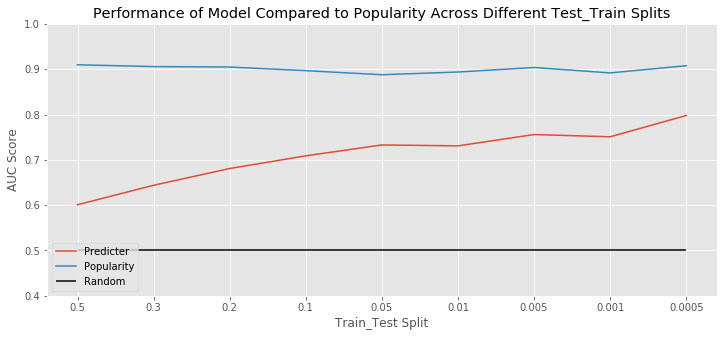

In [23]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.xticks(np.arange(0, 9, 1), train_set)

#Plot Predicter versus Popularity alone. 

for num, label in zip(range(2), ["Predicter", "Popularity"]):
    ax.plot([i[num] for i in scores], label = label)
ax.hlines(0.5, 0, 8, label = "Random")
ax.set(xlabel = "Train_Test Split", 
       ylabel = "AUC Score", 
       title = "Performance of Model Compared to Popularity Across Different Test_Train Splits",
      ylim = (0.4, 1))
_ = ax.legend(loc = 'best')
    